# Homework2

Team: AiCoders
Members:
* Alessio_Parato
* Jan31415
* *Vel*


Task: The goal is to design and implement forecasting models to learn how to exploit past observations in the input sequences to correctly predict the future.


## Connection and Imports

### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
path = '/content/drive/MyDrive/Colab Notebooks/Homework2/'
%cd /content/drive/MyDrive/Colab Notebooks/Homework2

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/Homework2


### Import libraries

In [19]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.model_selection import train_test_split

2.15.0


In [3]:
def save_model(model, model_name, path, mse=None, val_mse=None, mae=None, val_mae=None, plot=False):
  #
  #the functions saves the model and the history of a fit
  #
  if plot:
    tfk.utils.plot_model(model, to_file=path+'/model_pic.png', show_shapes=True, expand_nested=True)
  model.save(path+'/'+model_name)
  pd.DataFrame(mse).to_csv(path+'/'+model_name+'/mse.csv')
  pd.DataFrame(mae).to_csv(path+'/'+model_name+'/mae.csv')
  if val_mse!=None and val_mae!=None:
    pd.DataFrame(val_mse).to_csv(path+'/'+model_name+'/val_mse.csv')
    pd.DataFrame(val_mae).to_csv(path+'/'+model_name+'/val_mae.csv')

def load_model(path):
  #
  #the functions loads the model and the history of a fit
  #
  model = tfk.models.load_model(path)
  mse = pd.read_csv(path+'/mse.csv')
  val_mse = pd.read_csv(path+'/val_mse.csv')
  mae = pd.read_csv(path+'/mae.csv')
  val_mae = pd.read_csv(path+'/val_mae.csv')

  return (model, mse, val_mse, mae, val_mae)

## Load data and split it in train, validation and test set

* 'training_data.npy': numpy array of shape (48000, 2776). 48000 time series of length 2776.
* 'valid_periods.npy': numpy array of type (48000, 2), containing for each of the time series the start and end index of the current series, i.e. the part without padding.
* 'categories.npy': numpy array of shape (48000,), containing for each of the time series the code of its category. The possible categories are in {'A', 'B', 'C', 'D', 'E', 'F'}.

In [4]:
#loads the unzipped dataset and divides it into data and labels
t_d = np.load('Data/training_data.npy')
cate = np.load('Data/categories.npy')
v_p = np.load('Data/valid_periods.npy')
len_v_p = v_p[:,1]-v_p[:,0]
# Print shapes of the datasets
print(f"training shape: {t_d.shape}")
print(f"categories shape: {cate.shape}")
print(f"valid_periods shape: {v_p.shape}")

training shape: (48000, 2776)
categories shape: (48000,)
valid_periods shape: (48000, 2)


In [5]:
A = np.reshape((np.where(cate=='A')), 5728)
A_train, A_v_p, A_len_v_p = t_d[A], v_p[A], len_v_p[A]
B = np.reshape((np.where(cate=='B')), 10987)
B_train, B_v_p, B_len_v_p = t_d[B], v_p[B], len_v_p[B]
C = np.reshape((np.where(cate=='C')), 10017)
C_train, C_v_p, C_len_v_p = t_d[C], v_p[C], len_v_p[C]
D = np.reshape((np.where(cate=='D')), 10016)
D_train, D_v_p, D_len_v_p = t_d[D], v_p[D], len_v_p[D]
E = np.reshape((np.where(cate=='E')), 10975)
E_train, E_v_p, E_len_v_p = t_d[E], v_p[E], len_v_p[E]
F = np.reshape((np.where(cate=='F')), 277)
F_train, F_v_p, F_len_v_p = t_d[F], v_p[F], len_v_p[F]

In [6]:
def build_sequences(data, valid_periods, window=200, telescope=9, step=209):
    dataset = []
    labels = []
    da = data.copy()
    va_p = valid_periods.copy()

    for i in range(da.shape[0]):
      series = da[i,va_p[i,0]:va_p[i,1]]
      idx = 0
      while(idx+window+telescope < series.shape[0]):
        dataset.append(series[idx:idx+window])
        labels.append(series[idx+window:idx+window+telescope])
        idx = idx+step

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels
def build_sequences2(data, window=200, telescope=9, step=209):
    dataset = []
    labels = []
    da = data.copy()

    for series in da:
      idx = 0
      while(idx+window+telescope < series.shape[0]):
        dataset.append(series[idx:idx+window])
        labels.append(series[idx+window:idx+window+telescope])
        idx = idx+step

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [7]:
A_x, A_y = build_sequences(t_d[A], v_p[A], telescope=18, step=120)
print(f'Number of Training: {A_x.shape[0]}')
B_x, B_y = build_sequences(t_d[B], v_p[B],telescope=18, step=75)
print(f'Number of Training: {B_x.shape[0]}')
C_x, C_y = build_sequences(t_d[C], v_p[C],telescope=18, step=150)
print(f'Number of Training: {C_x.shape[0]}')
D_x, D_y = build_sequences(t_d[D], v_p[D],telescope=18, step=250)
print(f'Number of Training: {D_x.shape[0]}')
E_x, E_y = build_sequences(t_d[E], v_p[E],telescope=18, step=100)
print(f'Number of Training: {E_x.shape[0]}')
F_x, F_y = build_sequences(t_d[F], v_p[F],telescope=18, step=5)
print(f'Number of Training: {F_x.shape[0]}')

Number of Training: 5170
Number of Training: 5119
Number of Training: 5201
Number of Training: 5824
Number of Training: 5055
Number of Training: 2458


In [8]:
test_size = 0.2
Ax_t_v, Ax_t, Ay_t_v, Ay_t = train_test_split(A_x, A_y, random_state=seed, test_size=test_size)
Bx_t_v, Bx_t, By_t_v, By_t = train_test_split(B_x, B_y, random_state=seed, test_size=test_size)
Cx_t_v, Cx_t, Cy_t_v, Cy_t = train_test_split(C_x, C_y, random_state=seed, test_size=test_size)
Dx_t_v, Dx_t, Dy_t_v, Dy_t = train_test_split(D_x, D_y, random_state=seed, test_size=test_size)
Ex_t_v, Ex_t, Ey_t_v, Ey_t = train_test_split(E_x, E_y, random_state=seed, test_size=test_size)
Fx_t_v, Fx_t, Fy_t_v, Fy_t = train_test_split(F_x, F_y, random_state=seed, test_size=test_size)

In [9]:
t_list = []
for i in range(t_d.shape[0]):
  t_list.append(t_d[i,v_p[i,0]:])

In [10]:
tx, ty = build_sequences2(t_list, window=200, telescope=18, step=200)
print(tx.shape)

(23016, 200)


In [11]:
all_x = np.concatenate([A_x, B_x, C_x, D_x, E_x, F_x], axis=0)
all_y = np.concatenate([A_y, B_y, C_y, D_y, E_y, F_y], axis=0)
allx_t_v, allx_t, ally_t_v, ally_t = train_test_split(all_x, all_y, random_state=seed, test_size=0.2)

# Initialization and first training

In this file we created a model that contains all the other models.

In the beginning we would like to weight the input with a model called 'Sig' which stands for 'Signal'. It is a very simple model consisting of two dense layers. The last one must have 200 neurons and we decided to use the sigmoid function as activation function. We multiply the output of this model with the original model to get the weighted input.

As the main part we used a ResNet-like model as we created in the other file 'Homework2_RESNET.ipynb', eight Conv1D layers and one dense layer. In front of this model we added a LSTM layer for the recurrent part of the hole model.

At least we added a model called 'Residual'. As the input for this model we took the weighted input and the output of this model we added to the output of the ResNet-like model.
The main idea for this part was to create a model which calculates the error of the main-model. To achieve this we used BatchNormalization in the end of the this model.

First we trained the network with all categories simultaneously.

In [12]:
sig = model = tfk.Sequential([
        tfkl.Input(shape=200, name='INPUT'),
        tfkl.Dense(200, activation='relu', name='Dense_S'),
        tfkl.Dropout(rate=0.2, name='Drop_S'),
        tfkl.Dense(200, activation='sigmoid', name='Signal_S'),
    ], name='Sig')

input_layer = tfkl.Input(shape=(200,1), name='Input_RESNET-like')
x = tfkl.Conv1D(16, 10, padding='same', activation='relu', name='conv1_RESNET-like')(input_layer)
x = tfkl.Conv1D(32, 10, padding='same', activation='relu', name='conv2_RESNET-like')(x)
x1 = input_layer + x
x2 = tfkl.AveragePooling1D(4, name='avg1_RESNET-like')(x1)
x = tfkl.Conv1D(32, 10, padding='same', activation='relu', name='conv3_RESNET-like')(x2)
x = tfkl.Conv1D(32, 10, padding='same', activation='relu', name='conv4_RESNET-like')(x)
x = x + x2
x = tfkl.Conv1D(64, 20, padding='same', activation='relu', name='conv5_RESNET-like')(x)
x3= tfkl.AveragePooling1D(2, name='avg2_RESNET-like')(x)
x = tfkl.Conv1D(64, 10, padding='same', activation='relu', name='conv6_RESNET-like')(x3)
x = tfkl.Conv1D(64, 10, padding='same', activation='relu', name='conv7_RESNET-like')(x)
x = x3 +x
x = tfkl.Conv1D(128, 20, padding='same', activation='relu', name='conv8_RESNET-like')(x)
gap = tfkl.GlobalAveragePooling1D(name='gap_RESNET-like')(x)
output_layer = tfkl.Dense(18, activation='linear', name='output_RESNET-like')(gap)
model_RESNET = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='model_RESNET-like')

residual = model = tfk.Sequential([
        tfkl.Input(shape=(200,1), name='INPUT_Residual'),
        tfkl.Conv1D(64, 200, padding='valid', activation='relu', name='conv_Residual'),
        tfkl.GlobalAveragePooling1D(name='gap_Residual'),
        tfkl.Dropout(rate=0.2, name='Drop_Residual'),
        tfkl.Dense(64, activation='relu', name='Dense_Residual'),
        tfkl.BatchNormalization(name='Norm_Residual'),
        tfkl.Dense(18, activation='linear', name='output_Residual'),
    ], name='Residual')

input = tfkl.Input(shape=200, name='INPUT')
out_sig = sig(input)
add1 = tf.expand_dims(tfkl.Multiply(name='Mult')([input, out_sig]), axis=2)

out_residual = residual(add1)

out_lstm = tfkl.LSTM(200, return_sequences=False, name='LSTM')(add1)

out_RESNET = model_RESNET(out_lstm)

output = tfkl.Add(name='Add')([out_RESNET, out_residual])

model = tf.keras.Model(inputs=input, outputs=output, name='Combination_of_all')

Model: "Combination_of_all"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, 200)]                0         []                            
                                                                                                  
 Sig (Sequential)            (None, 200)                  80400     ['INPUT[0][0]']               
                                                                                                  
 Mult (Multiply)             (None, 200)                  0         ['INPUT[0][0]',               
                                                                     'Sig[0][0]']                 
                                                                                                  
 tf.expand_dims (TFOpLambda  (None, 200, 1)               0         ['Mult[0][0]'

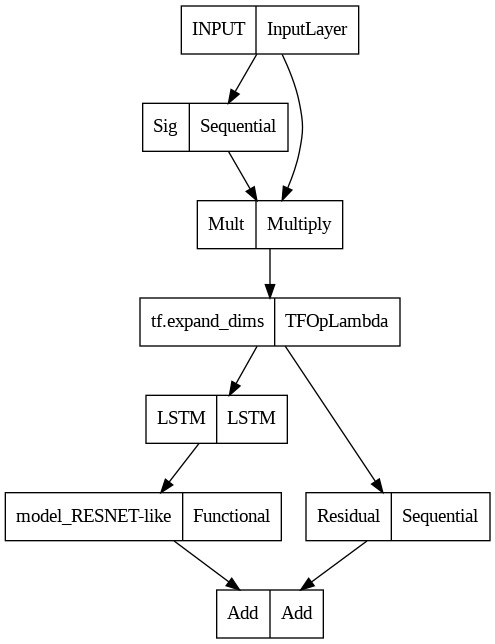

In [29]:
model.summary()
tfk.utils.plot_model(model, to_file='Cate_RESNET/V1/model.png')

Model: "Sig"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_S (Dense)             (None, 200)               40200     
                                                                 
 Drop_S (Dropout)            (None, 200)               0         
                                                                 
 Signal_S (Dense)            (None, 200)               40200     
                                                                 
Total params: 80400 (314.06 KB)
Trainable params: 80400 (314.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


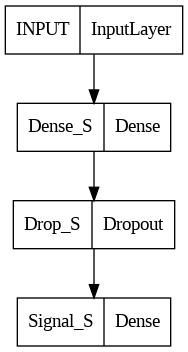

In [30]:
model.get_layer('Sig').summary()
tfk.utils.plot_model(model.get_layer('Sig'), to_file='Cate_RESNET/V1/model_Sig.png')

Model: "Residual"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_Residual (Conv1D)      (None, 1, 64)             12864     
                                                                 
 gap_Residual (GlobalAverag  (None, 64)                0         
 ePooling1D)                                                     
                                                                 
 Drop_Residual (Dropout)     (None, 64)                0         
                                                                 
 Dense_Residual (Dense)      (None, 64)                4160      
                                                                 
 Norm_Residual (BatchNormal  (None, 64)                256       
 ization)                                                        
                                                                 
 output_Residual (Dense)     (None, 18)                117

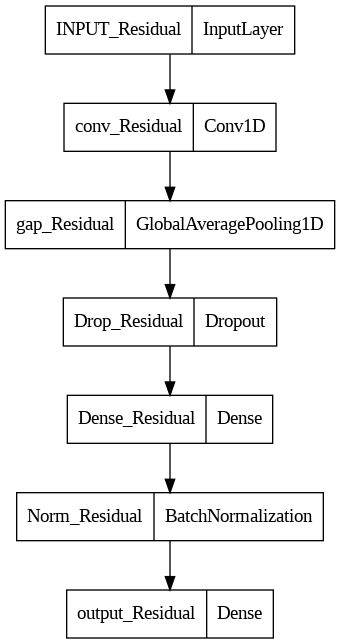

In [31]:
model.get_layer('Residual').summary()
tfk.utils.plot_model(model.get_layer('Residual'), to_file='Cate_RESNET/V1/model_Residual.png')

Model: "model_RESNET-like"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_RESNET-like (InputLa  [(None, 200, 1)]             0         []                            
 yer)                                                                                             
                                                                                                  
 conv1_RESNET-like (Conv1D)  (None, 200, 16)              176       ['Input_RESNET-like[0][0]']   
                                                                                                  
 conv2_RESNET-like (Conv1D)  (None, 200, 32)              5152      ['conv1_RESNET-like[0][0]']   
                                                                                                  
 tf.__operators__.add (TFOp  (None, 200, 32)              0         ['Input_RESNET

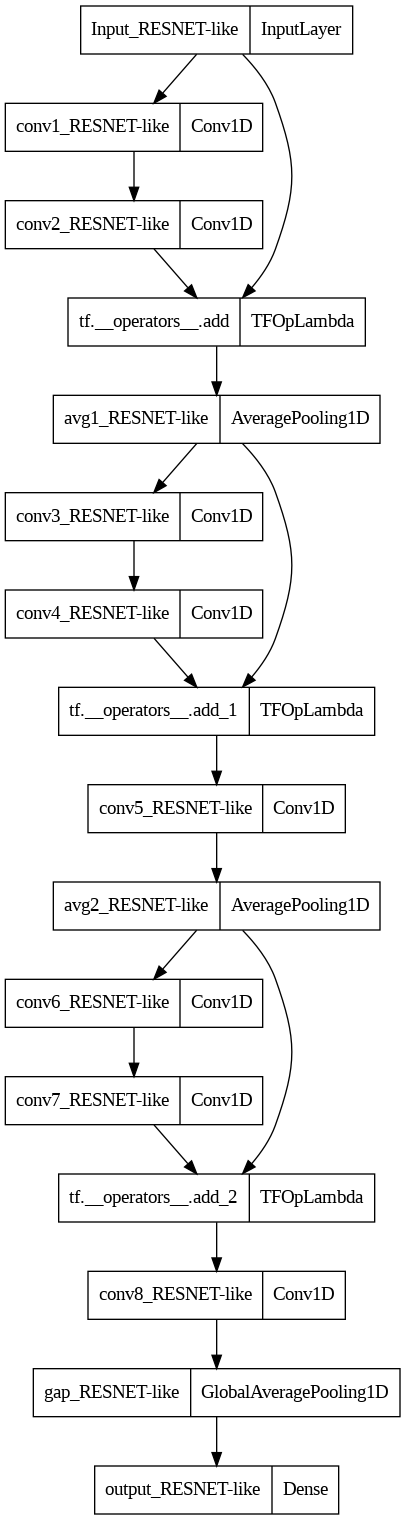

In [32]:
model.get_layer('model_RESNET-like').summary()
tfk.utils.plot_model(model.get_layer('model_RESNET-like'), to_file='Cate_RESNET/V1/model_RESNET-like.png')

In [ ]:
model.compile(loss='mse', optimizer=tfk.optimizers.Adam(learning_rate=0.001), metrics=['mse', 'mae'])
history = model.fit(
    x = allx_t_v,
    y = ally_t_v,
    batch_size = 256, epochs = 20, validation_split=.1,
    callbacks = [tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.19, min_lr=1e-5)]
  ).history
save_model(model, 'model1_all', 'Cate_RESNET/V1', history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)
del model
model = load_model('Cate_RESNET/V1/model1_all')[0]
model.compile(loss='mse', optimizer=tfk.optimizers.Adam(learning_rate=0.001), metrics=['mse', 'mae'])
history = model.fit(
    x = allx_t_v,
    y = ally_t_v,
    batch_size = 128, epochs = 20, validation_split=.1,
    callbacks = [tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.19, min_lr=1e-5)]
  ).history
save_model(model, 'model2_all', 'Cate_RESNET/V1', history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)
del model

Epoch 1/20
82/82 [==============================] - 159s 2s/step - loss: 0.0455 - mse: 0.0455 - mae: 0.1377 - val_loss: 0.0123 - val_mse: 0.0123 - val_mae: 0.0782 - lr: 0.0010
Epoch 2/20
82/82 [==============================] - 154s 2s/step - loss: 0.0122 - mse: 0.0122 - mae: 0.0763 - val_loss: 0.0129 - val_mse: 0.0129 - val_mae: 0.0803 - lr: 0.0010
Epoch 3/20
82/82 [==============================] - 155s 2s/step - loss: 0.0119 - mse: 0.0119 - mae: 0.0754 - val_loss: 0.0115 - val_mse: 0.0115 - val_mae: 0.0749 - lr: 0.0010
Epoch 4/20
82/82 [==============================] - 151s 2s/step - loss: 0.0117 - mse: 0.0117 - mae: 0.0743 - val_loss: 0.0113 - val_mse: 0.0113 - val_mae: 0.0739 - lr: 0.0010
Epoch 5/20
82/82 [==============================] - 155s 2s/step - loss: 0.0114 - mse: 0.0114 - mae: 0.0727 - val_loss: 0.0109 - val_mse: 0.0109 - val_mae: 0.0716 - lr: 0.0010
Epoch 6/20
82/82 [==============================] - 158s 2s/step - loss: 0.0111 - mse: 0.0111 - mae: 0.0718 - val_loss: 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-f5b06113d5b2>", line 29, in <cell line: 29>
    save_model(model, 'model3_all', 'Cate_RESNET/V1', history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)
  File "<ipython-input-3-96eea08c7d47>", line 7, in save_model
    model.save(path+'/'+model_name)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/lib/io/file_io.py", line 513, in recursive_create_dir_v2
    _pywrap_file_io.RecursivelyCreateDir(compat.path_to_bytes(path))
tensorflow.python.framework.errors_impl.FailedPreconditionError: Cate_RESNET; Transport endpoint is not connected

During handling of the above e

In [ ]:
model = load_model('Cate_RESNET/V1/model2_all')[0]
model.compile(loss='mse', optimizer=tfk.optimizers.AdamW(learning_rate=0.001), metrics=['mse', 'mae'])
history = model.fit(
    x = allx_t_v,
    y = ally_t_v,
    batch_size = 64, epochs = 35, validation_split=.1,
    callbacks = [tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.19, min_lr=1e-5)]
  ).history
save_model(model, 'model3_all', 'Cate_RESNET/V1', history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)

Epoch 1/35
325/325 [==============================] - 247s 741ms/step - loss: 0.0089 - mse: 0.0089 - mae: 0.0639 - val_loss: 0.0097 - val_mse: 0.0097 - val_mae: 0.0696 - lr: 0.0010
Epoch 2/35
325/325 [==============================] - 236s 728ms/step - loss: 0.0089 - mse: 0.0089 - mae: 0.0638 - val_loss: 0.0093 - val_mse: 0.0093 - val_mae: 0.0677 - lr: 0.0010
Epoch 3/35
325/325 [==============================] - 228s 702ms/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0625 - val_loss: 0.0083 - val_mse: 0.0083 - val_mae: 0.0608 - lr: 0.0010
Epoch 4/35
325/325 [==============================] - 231s 711ms/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0626 - val_loss: 0.0084 - val_mse: 0.0084 - val_mae: 0.0605 - lr: 0.0010
Epoch 5/35
325/325 [==============================] - 230s 709ms/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0617 - val_loss: 0.0084 - val_mse: 0.0084 - val_mae: 0.0615 - lr: 0.0010
Epoch 6/35
325/325 [==============================] - 227s 697ms/step - loss: 0.0084 - mse: 0.0

In [ ]:
print(model.evaluate(allx_t, ally_t))

181/181 [==============================] - 28s 156ms/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0565
[0.00784445833414793, 0.00784445833414793, 0.05648916959762573]


# train each category individually to specialise the network

In [ ]:
model = load_model('Cate_RESNET/V1/model3_all')[0]
model.summary()

Model: "Combination_of_all"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, 200)]                0         []                            
                                                                                                  
 Sig (Sequential)            (None, 200)                  80400     ['INPUT[0][0]']               
                                                                                                  
 Mult (Multiply)             (None, 200)                  0         ['INPUT[0][0]',               
                                                                     'Sig[0][0]']                 
                                                                                                  
 tf.expand_dims_1 (TFOpLamb  (None, 200, 1)               0         ['Mult[0][0]'

In [ ]:
model.compile(loss='mse', optimizer=tfk.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01), metrics=['mse', 'mae'])
history = model.fit(
    x = allx_t_v,
    y = ally_t_v,
    batch_size = 128, epochs = 20, validation_split=.1,
    callbacks = [tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.19, min_lr=1e-5)]
  ).history

Epoch 1/20
163/163 [==============================] - 204s 1s/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0582 - val_loss: 0.0077 - val_mse: 0.0077 - val_mae: 0.0583 - lr: 0.0010
Epoch 2/20
163/163 [==============================] - 199s 1s/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0571 - val_loss: 0.0095 - val_mse: 0.0095 - val_mae: 0.0705 - lr: 0.0010
Epoch 3/20
163/163 [==============================] - 203s 1s/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0573 - val_loss: 0.0075 - val_mse: 0.0075 - val_mae: 0.0568 - lr: 0.0010
Epoch 4/20
163/163 [==============================] - 201s 1s/step - loss: 0.0073 - mse: 0.0073 - mae: 0.0569 - val_loss: 0.0079 - val_mse: 0.0079 - val_mae: 0.0587 - lr: 0.0010
Epoch 5/20
163/163 [==============================] - 200s 1s/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0574 - val_loss: 0.0092 - val_mse: 0.0092 - val_mae: 0.0665 - lr: 0.0010
Epoch 6/20
163/163 [==============================] - 200s 1s/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0579 

In [ ]:
print(model.evaluate(allx_t, ally_t))

181/181 [==============================] - 31s 168ms/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0556
[0.007646783720701933, 0.007646783720701933, 0.055566299706697464]


In [ ]:
save_model(model, 'model4_all', 'Cate_RESNET/V1', history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)

In [ ]:
model = load_model('Cate_RESNET/V1/model4_all')[0]
print(model.evaluate(Ax_t, Ay_t, verbose=0))
print(model.evaluate(Bx_t, By_t, verbose=0))
print(model.evaluate(Cx_t, Cy_t, verbose=0))
print(model.evaluate(Dx_t, Dy_t, verbose=0))
print(model.evaluate(Ex_t, Ey_t, verbose=0))
print(model.evaluate(Fx_t, Fy_t, verbose=0))

[0.005785367917269468, 0.005785367917269468, 0.05158805474638939]
[0.007667708210647106, 0.007667708210647106, 0.05599546432495117]
[0.006684263702481985, 0.006684263702481985, 0.05364469066262245]
[0.00681175896897912, 0.00681175896897912, 0.054354649037122726]
[0.005285223945975304, 0.005285223945975304, 0.04801535606384277]
[0.004846076015383005, 0.004846076015383005, 0.03290961682796478]


In [ ]:
modelA = load_model('Cate_RESNET/V1/model1_A')[0]
modelB = load_model('Cate_RESNET/V1/model1_B')[0]
modelC = load_model('Cate_RESNET/V1/model1_C')[0]
modelD = load_model('Cate_RESNET/V1/model1_D')[0]
modelE = load_model('Cate_RESNET/V1/model1_E')[0]
modelF = load_model('Cate_RESNET/V1/model1_F')[0]
print(modelA.evaluate(Ax_t, Ay_t, verbose=0))
print(modelB.evaluate(Bx_t, By_t, verbose=0))
print(modelC.evaluate(Cx_t, Cy_t, verbose=0))
print(modelD.evaluate(Dx_t, Dy_t, verbose=0))
print(modelE.evaluate(Ex_t, Ey_t, verbose=0))
print(modelF.evaluate(Fx_t, Fy_t, verbose=0))

[0.005950047168880701, 0.005950047168880701, 0.05179620161652565]
[0.007934695109724998, 0.007934695109724998, 0.05695828050374985]
[0.007323900703340769, 0.007323900703340769, 0.0557699091732502]
[0.00670767854899168, 0.00670767854899168, 0.05415666475892067]
[0.005002658814191818, 0.005002658814191818, 0.046846646815538406]
[0.0037820234429091215, 0.0037820234429091215, 0.02841927856206894]


## Training

In [ ]:
model = load_model('Cate_RESNET/V1/model4_all')[0]
model.compile(loss='mse', optimizer=tfk.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01), metrics=['mse', 'mae'])
history = model.fit(
    x = Ax_t_v,
    y = Ay_t_v,
    batch_size = 128, epochs = 200, validation_split=.1,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.19, min_lr=1e-5)]
  ).history
save_model(model, 'model1_A', 'Cate_RESNET/V1', history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)

Epoch 1/200
30/30 [==============================] - 41s 1s/step - loss: 0.0069 - mse: 0.0069 - mae: 0.0583 - val_loss: 0.0068 - val_mse: 0.0068 - val_mae: 0.0581 - lr: 0.0010
Epoch 2/200
30/30 [==============================] - 36s 1s/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0554 - val_loss: 0.0070 - val_mse: 0.0070 - val_mae: 0.0590 - lr: 0.0010
Epoch 3/200
30/30 [==============================] - 36s 1s/step - loss: 0.0065 - mse: 0.0065 - mae: 0.0564 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0557 - lr: 0.0010
Epoch 4/200
30/30 [==============================] - 34s 1s/step - loss: 0.0061 - mse: 0.0061 - mae: 0.0543 - val_loss: 0.0074 - val_mse: 0.0074 - val_mae: 0.0615 - lr: 0.0010
Epoch 5/200
30/30 [==============================] - 34s 1s/step - loss: 0.0062 - mse: 0.0062 - mae: 0.0547 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0567 - lr: 0.0010
Epoch 6/200
30/30 [==============================] - 40s 1s/step - loss: 0.0061 - mse: 0.0061 - mae: 0.0547 - val_loss: 

In [ ]:
model = load_model('Cate_RESNET/V1/model4_all')[0]
model.compile(loss='mse', optimizer=tfk.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01), metrics=['mse', 'mae'])
history = model.fit(
    x = Bx_t_v,
    y = By_t_v,
    batch_size = 128, epochs = 200, validation_split=.1,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.19, min_lr=1e-5)]
  ).history
save_model(model, 'model1_B', 'Cate_RESNET/V1', history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)

Epoch 1/200
29/29 [==============================] - 44s 1s/step - loss: 0.0090 - mse: 0.0090 - mae: 0.0625 - val_loss: 0.0105 - val_mse: 0.0105 - val_mae: 0.0685 - lr: 0.0010
Epoch 2/200
29/29 [==============================] - 38s 1s/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0602 - val_loss: 0.0094 - val_mse: 0.0094 - val_mae: 0.0608 - lr: 0.0010
Epoch 3/200
29/29 [==============================] - 35s 1s/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0591 - val_loss: 0.0099 - val_mse: 0.0099 - val_mae: 0.0615 - lr: 0.0010
Epoch 4/200
29/29 [==============================] - 34s 1s/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0595 - val_loss: 0.0101 - val_mse: 0.0101 - val_mae: 0.0639 - lr: 0.0010
Epoch 5/200
29/29 [==============================] - 39s 1s/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0588 - val_loss: 0.0099 - val_mse: 0.0099 - val_mae: 0.0628 - lr: 0.0010
Epoch 6/200
29/29 [==============================] - 34s 1s/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0591 - val_loss: 

In [ ]:
model = load_model('Cate_RESNET/V1/model4_all')[0]
model.compile(loss='mse', optimizer=tfk.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01), metrics=['mse', 'mae'])
history = model.fit(
    x = Cx_t_v,
    y = Cy_t_v,
    batch_size = 128, epochs = 200, validation_split=.1,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.19, min_lr=1e-5)]
  ).history
save_model(model, 'model1_C', 'Cate_RESNET/V1', history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)

Epoch 1/200
30/30 [==============================] - 42s 1s/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0630 - val_loss: 0.0077 - val_mse: 0.0077 - val_mae: 0.0615 - lr: 0.0010
Epoch 2/200
30/30 [==============================] - 34s 1s/step - loss: 0.0075 - mse: 0.0075 - mae: 0.0587 - val_loss: 0.0074 - val_mse: 0.0074 - val_mae: 0.0586 - lr: 0.0010
Epoch 3/200
30/30 [==============================] - 35s 1s/step - loss: 0.0075 - mse: 0.0075 - mae: 0.0585 - val_loss: 0.0072 - val_mse: 0.0072 - val_mae: 0.0591 - lr: 0.0010
Epoch 4/200
30/30 [==============================] - 37s 1s/step - loss: 0.0073 - mse: 0.0073 - mae: 0.0579 - val_loss: 0.0076 - val_mse: 0.0076 - val_mae: 0.0609 - lr: 0.0010
Epoch 5/200
30/30 [==============================] - 37s 1s/step - loss: 0.0071 - mse: 0.0071 - mae: 0.0573 - val_loss: 0.0069 - val_mse: 0.0069 - val_mae: 0.0578 - lr: 0.0010
Epoch 6/200
30/30 [==============================] - 34s 1s/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0581 - val_loss: 

In [ ]:
model = load_model('Cate_RESNET/V1/model4_all')[0]
model.compile(loss='mse', optimizer=tfk.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01), metrics=['mse', 'mae'])
history = model.fit(
    x = Dx_t_v,
    y = Dy_t_v,
    batch_size = 128, epochs = 200, validation_split=.1,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.19, min_lr=1e-5)]
  ).history
save_model(model, 'model1_D', 'Cate_RESNET/V1', history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)

Epoch 1/200
33/33 [==============================] - 49s 1s/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0610 - val_loss: 0.0084 - val_mse: 0.0084 - val_mae: 0.0643 - lr: 0.0010
Epoch 2/200
33/33 [==============================] - 40s 1s/step - loss: 0.0070 - mse: 0.0070 - mae: 0.0576 - val_loss: 0.0076 - val_mse: 0.0076 - val_mae: 0.0596 - lr: 0.0010
Epoch 3/200
33/33 [==============================] - 41s 1s/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0565 - val_loss: 0.0074 - val_mse: 0.0074 - val_mae: 0.0601 - lr: 0.0010
Epoch 4/200
33/33 [==============================] - 43s 1s/step - loss: 0.0069 - mse: 0.0069 - mae: 0.0573 - val_loss: 0.0079 - val_mse: 0.0079 - val_mae: 0.0637 - lr: 0.0010
Epoch 5/200
33/33 [==============================] - 41s 1s/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0562 - val_loss: 0.0079 - val_mse: 0.0079 - val_mae: 0.0639 - lr: 0.0010
Epoch 6/200
33/33 [==============================] - 39s 1s/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0560 - val_loss: 

In [ ]:
model = load_model('Cate_RESNET/V1/model4_all')[0]
model.compile(loss='mse', optimizer=tfk.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01), metrics=['mse', 'mae'])
history = model.fit(
    x = Ex_t_v,
    y = Ey_t_v,
    batch_size = 128, epochs = 200, validation_split=.1,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.19, min_lr=1e-5)]
  ).history
save_model(model, 'model1_E', 'Cate_RESNET/V1', history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)

Epoch 1/200
29/29 [==============================] - 43s 1s/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0554 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0523 - lr: 0.0010
Epoch 2/200
29/29 [==============================] - 33s 1s/step - loss: 0.0059 - mse: 0.0059 - mae: 0.0516 - val_loss: 0.0061 - val_mse: 0.0061 - val_mae: 0.0508 - lr: 0.0010
Epoch 3/200
29/29 [==============================] - 34s 1s/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0503 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0511 - lr: 0.0010
Epoch 4/200
29/29 [==============================] - 33s 1s/step - loss: 0.0057 - mse: 0.0057 - mae: 0.0510 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0524 - lr: 0.0010
Epoch 5/200
29/29 [==============================] - 36s 1s/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0498 - val_loss: 0.0065 - val_mse: 0.0065 - val_mae: 0.0530 - lr: 0.0010
Epoch 6/200
29/29 [==============================] - 37s 1s/step - loss: 0.0054 - mse: 0.0054 - mae: 0.0494 - val_loss: 

In [ ]:
model = load_model('Cate_RESNET/V1/model4_all')[0]
model.compile(loss='mse', optimizer=tfk.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01), metrics=['mse', 'mae'])
history = model.fit(
    x = Fx_t_v,
    y = Fy_t_v,
    batch_size = 128, epochs = 200, validation_split=.1,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.19, min_lr=1e-5)]
  ).history
save_model(model, 'model1_F', 'Cate_RESNET/V1', history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)

Epoch 1/200
14/14 [==============================] - 26s 1s/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0412 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0361 - lr: 0.0010
Epoch 2/200
14/14 [==============================] - 16s 1s/step - loss: 0.0050 - mse: 0.0050 - mae: 0.0365 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0382 - lr: 0.0010
Epoch 3/200
14/14 [==============================] - 16s 1s/step - loss: 0.0044 - mse: 0.0044 - mae: 0.0339 - val_loss: 0.0042 - val_mse: 0.0042 - val_mae: 0.0409 - lr: 0.0010
Epoch 4/200
14/14 [==============================] - 16s 1s/step - loss: 0.0044 - mse: 0.0044 - mae: 0.0322 - val_loss: 0.0045 - val_mse: 0.0045 - val_mae: 0.0443 - lr: 0.0010
Epoch 5/200
14/14 [==============================] - 16s 1s/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0326 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0442 - lr: 0.0010
Epoch 6/200
14/14 [==============================] - 17s 1s/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0319 - val_loss: 

# Train again all categories simultaneously

In this section we decided to train again all categories simultaneously because the combined model consisting of the models trained individually generated a bigger MSE than the one trained with all categories simultaneously.

## Validation of the networks trained with all categories

In [ ]:
model4 = load_model('Cate_RESNET/V1/model4_all')[0]
print(model4.evaluate(allx_t, ally_t, verbose=0))
print(model4.evaluate(Ax_t, Ay_t, verbose=0))
print(model4.evaluate(Bx_t, By_t, verbose=0))
print(model4.evaluate(Cx_t, Cy_t, verbose=0))
print(model4.evaluate(Dx_t, Dy_t, verbose=0))
print(model4.evaluate(Ex_t, Ey_t, verbose=0))
print(model4.evaluate(Fx_t, Fy_t, verbose=0))

181/181 [==============================] - 28s 146ms/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0556
[0.007646783720701933, 0.007646783720701933, 0.055566299706697464]
[0.005785367917269468, 0.005785367917269468, 0.05158805474638939]
[0.007667708210647106, 0.007667708210647106, 0.05599546432495117]
[0.006684263702481985, 0.006684263702481985, 0.05364469066262245]
[0.00681175896897912, 0.00681175896897912, 0.054354649037122726]
[0.005285223945975304, 0.005285223945975304, 0.04801535606384277]
[0.004846076015383005, 0.004846076015383005, 0.03290961682796478]


In [ ]:
model4_1 = load_model('Cate_RESNET/V1/model4_1_all')[0]
print(model4_1.evaluate(allx_t, ally_t, verbose=0))
print(model4_1.evaluate(Ax_t, Ay_t, verbose=0))
print(model4_1.evaluate(Bx_t, By_t, verbose=0))
print(model4_1.evaluate(Cx_t, Cy_t, verbose=0))
print(model4_1.evaluate(Dx_t, Dy_t, verbose=0))
print(model4_1.evaluate(Ex_t, Ey_t, verbose=0))
print(model4_1.evaluate(Fx_t, Fy_t, verbose=0))

[0.007505855523049831, 0.007505855523049831, 0.05497652292251587]
[0.005490210372954607, 0.005490210372954607, 0.05030364915728569]
[0.0072355312295258045, 0.0072355312295258045, 0.05437439680099487]
[0.006260520778596401, 0.006260520778596401, 0.05195048078894615]
[0.006446869112551212, 0.006446869112551212, 0.05275236815214157]
[0.00491901533678174, 0.00491901533678174, 0.046579696238040924]
[0.004441221244633198, 0.004441221244633198, 0.031292568892240524]


In [ ]:
model5 = load_model('Cate_RESNET/V1/model5_all')[0]
print(model5.evaluate(allx_t, ally_t, verbose=0))
print(model5.evaluate(Ax_t, Ay_t, verbose=0))
print(model5.evaluate(Bx_t, By_t, verbose=0))
print(model5.evaluate(Cx_t, Cy_t, verbose=0))
print(model5.evaluate(Dx_t, Dy_t, verbose=0))
print(model5.evaluate(Ex_t, Ey_t, verbose=0))
print(model5.evaluate(Fx_t, Fy_t, verbose=0))

[0.0075406283140182495, 0.0075406283140182495, 0.05500560998916626]
[0.005475774873048067, 0.005475774873048067, 0.050269756466150284]
[0.007297372445464134, 0.007297372445464134, 0.054417867213487625]
[0.006278127431869507, 0.006278127431869507, 0.0518534854054451]
[0.00652458518743515, 0.00652458518743515, 0.052990831434726715]
[0.004972777795046568, 0.004972777795046568, 0.046617042273283005]
[0.004509297199547291, 0.004509297199547291, 0.03152111917734146]


In [ ]:
model6 = load_model('Cate_RESNET/V1/model6_all')[0]
print(model6.evaluate(allx_t, ally_t, verbose=0))
print(model6.evaluate(Ax_t, Ay_t, verbose=0))
print(model6.evaluate(Bx_t, By_t, verbose=0))
print(model6.evaluate(Cx_t, Cy_t, verbose=0))
print(model6.evaluate(Dx_t, Dy_t, verbose=0))
print(model6.evaluate(Ex_t, Ey_t, verbose=0))
print(model6.evaluate(Fx_t, Fy_t, verbose=0))

[0.007512006442993879, 0.007512006442993879, 0.05503308027982712]
[0.005461286753416061, 0.005461286753416061, 0.0501803457736969]
[0.007162547204643488, 0.007162547204643488, 0.05411297082901001]
[0.006134101189672947, 0.006134101189672947, 0.0515739805996418]
[0.006403709761798382, 0.006403709761798382, 0.05264527350664139]
[0.00501966243609786, 0.00501966243609786, 0.0468178391456604]
[0.004321620333939791, 0.004321620333939791, 0.030987167730927467]


In [ ]:
model7 = load_model('Cate_RESNET/V1/model7_all')[0]
print(model7.evaluate(allx_t, ally_t, verbose=0))
print(model7.evaluate(Ax_t, Ay_t, verbose=0))
print(model7.evaluate(Bx_t, By_t, verbose=0))
print(model7.evaluate(Cx_t, Cy_t, verbose=0))
print(model7.evaluate(Dx_t, Dy_t, verbose=0))
print(model7.evaluate(Ex_t, Ey_t, verbose=0))
print(model7.evaluate(Fx_t, Fy_t, verbose=0))

[0.007479965221136808, 0.007479965221136808, 0.054851897060871124]
[0.005316845141351223, 0.005316845141351223, 0.05000494047999382]
[0.006945028901100159, 0.006945028901100159, 0.0535847470164299]
[0.006025221198797226, 0.006025221198797226, 0.05098777264356613]
[0.006338449195027351, 0.006338449195027351, 0.05214913934469223]
[0.004933185409754515, 0.004933185409754515, 0.04630739614367485]
[0.0042412797920405865, 0.0042412797920405865, 0.03069920837879181]


## Repetitive training with all categories simultaneously

The repetitive training leads to overfitting which we saw in the online submission.

In [ ]:
model = load_model('Cate_RESNET/V1/model4_all')[0]
model.compile(loss='mse', optimizer=tfk.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01), metrics=['mse', 'mae'])
history = model.fit(
    x = allx_t_v,
    y = ally_t_v,
    batch_size = 512, epochs = 200, validation_split=.1,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.19, min_lr=1e-5)]
  ).history
save_model(model, 'model5_all', 'Cate_RESNET/V1', history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)

Epoch 1/200
41/41 [==============================] - 204s 5s/step - loss: 0.0071 - mse: 0.0071 - mae: 0.0563 - val_loss: 0.0072 - val_mse: 0.0072 - val_mae: 0.0548 - lr: 0.0010
Epoch 2/200
41/41 [==============================] - 181s 4s/step - loss: 0.0065 - mse: 0.0065 - mae: 0.0530 - val_loss: 0.0072 - val_mse: 0.0072 - val_mae: 0.0552 - lr: 0.0010
Epoch 3/200
41/41 [==============================] - 183s 4s/step - loss: 0.0065 - mse: 0.0065 - mae: 0.0532 - val_loss: 0.0072 - val_mse: 0.0072 - val_mae: 0.0565 - lr: 0.0010
Epoch 4/200
41/41 [==============================] - 179s 4s/step - loss: 0.0065 - mse: 0.0065 - mae: 0.0533 - val_loss: 0.0073 - val_mse: 0.0073 - val_mae: 0.0562 - lr: 0.0010
Epoch 5/200
41/41 [==============================] - 186s 5s/step - loss: 0.0065 - mse: 0.0065 - mae: 0.0532 - val_loss: 0.0071 - val_mse: 0.0071 - val_mae: 0.0548 - lr: 0.0010
Epoch 6/200
41/41 [==============================] - 180s 4s/step - loss: 0.0065 - mse: 0.0065 - mae: 0.0530 - val_

In [ ]:
model = load_model('Cate_RESNET/V1/model5_all')[0]
model.compile(loss='mse', optimizer=tfk.optimizers.AdamW(learning_rate=0.001, weight_decay=0.03), metrics=['mse', 'mae'])
history = model.fit(
    x = allx_t_v,
    y = ally_t_v,
    batch_size = 256, epochs = 200, validation_split=.1,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001, patience=10, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.19, min_lr=1e-5)]
  ).history
save_model(model, 'model6_all', 'Cate_RESNET/V1', history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)

Epoch 1/200
82/82 [==============================] - 194s 2s/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0544 - val_loss: 0.0074 - val_mse: 0.0074 - val_mae: 0.0568 - lr: 0.0010
Epoch 2/200
82/82 [==============================] - 192s 2s/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0532 - val_loss: 0.0075 - val_mse: 0.0075 - val_mae: 0.0576 - lr: 0.0010
Epoch 3/200
82/82 [==============================] - 189s 2s/step - loss: 0.0065 - mse: 0.0065 - mae: 0.0537 - val_loss: 0.0072 - val_mse: 0.0072 - val_mae: 0.0557 - lr: 0.0010
Epoch 4/200
82/82 [==============================] - 191s 2s/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0539 - val_loss: 0.0073 - val_mse: 0.0073 - val_mae: 0.0560 - lr: 0.0010
Epoch 5/200
82/82 [==============================] - 183s 2s/step - loss: 0.0065 - mse: 0.0065 - mae: 0.0533 - val_loss: 0.0074 - val_mse: 0.0074 - val_mae: 0.0571 - lr: 0.0010
Epoch 6/200
82/82 [==============================] - 191s 2s/step - loss: 0.0065 - mse: 0.0065 - mae: 0.0536 - val_

In [ ]:
model = load_model('Cate_RESNET/V1/model6_all')[0]
model.compile(loss='mse', optimizer=tfk.optimizers.AdamW(learning_rate=0.001, weight_decay=0.03), metrics=['mse', 'mae'])
history = model.fit(
    x = allx_t_v,
    y = ally_t_v,
    batch_size = 128, epochs = 200, validation_split=.1,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001, patience=10, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.19, min_lr=1e-5)]
  ).history
save_model(model, 'model7_all', 'Cate_RESNET/V1', history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)

Epoch 1/200
163/163 [==============================] - 214s 1s/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0547 - val_loss: 0.0075 - val_mse: 0.0075 - val_mae: 0.0579 - lr: 0.0010
Epoch 2/200
163/163 [==============================] - 206s 1s/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0543 - val_loss: 0.0078 - val_mse: 0.0078 - val_mae: 0.0602 - lr: 0.0010
Epoch 3/200
163/163 [==============================] - 205s 1s/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0544 - val_loss: 0.0076 - val_mse: 0.0076 - val_mae: 0.0590 - lr: 0.0010
Epoch 4/200
163/163 [==============================] - 206s 1s/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0541 - val_loss: 0.0073 - val_mse: 0.0073 - val_mae: 0.0565 - lr: 0.0010
Epoch 5/200
163/163 [==============================] - 203s 1s/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0544 - val_loss: 0.0079 - val_mse: 0.0079 - val_mae: 0.0593 - lr: 0.0010
Epoch 6/200
163/163 [==============================] - 203s 1s/step - loss: 0.0066 - mse: 0.0066 - mae: 0

## Training with more data

Also the training with more data leads to a bigger MSE in the online submission.

In [ ]:
A_x, A_y = build_sequences(t_d[A], v_p[A], telescope=18, step=70)
print(f'Number of Training: {A_x.shape[0]}')
B_x, B_y = build_sequences(t_d[B], v_p[B],telescope=18, step=45)
print(f'Number of Training: {B_x.shape[0]}')
C_x, C_y = build_sequences(t_d[C], v_p[C],telescope=18, step=75)
print(f'Number of Training: {C_x.shape[0]}')
D_x, D_y = build_sequences(t_d[D], v_p[D],telescope=18, step=125)
print(f'Number of Training: {D_x.shape[0]}')
E_x, E_y = build_sequences(t_d[E], v_p[E],telescope=18, step=65)
print(f'Number of Training: {E_x.shape[0]}')
F_x, F_y = build_sequences(t_d[F], v_p[F],telescope=18, step=2)
print(f'Number of Training: {F_x.shape[0]}')

Number of Training: 7352
Number of Training: 7667
Number of Training: 7699
Number of Training: 7232
Number of Training: 8542
Number of Training: 6074


In [ ]:
all_x = np.concatenate([A_x, B_x, C_x, D_x, E_x, F_x], axis=0)
all_y = np.concatenate([A_y, B_y, C_y, D_y, E_y, F_y], axis=0)
allx_t_v, allx_t, ally_t_v, ally_t = train_test_split(all_x, all_y, random_state=seed, test_size=0.2)

In [ ]:
model = load_model('Cate_RESNET/V1/model4_all')[0]
model.compile(loss='mse', optimizer=tfk.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01), metrics=['mse', 'mae'])
history = model.fit(
    x = allx_t_v,
    y = ally_t_v,
    batch_size = 128, epochs = 200, validation_split=.1,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, mode='min', patience=10, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.19, min_lr=1e-5)]
  ).history
save_model(model, 'model4_1_all', 'Cate_RESNET/V1', history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)

Epoch 1/200
163/163 [==============================] - 183s 1s/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0566 - val_loss: 0.0074 - val_mse: 0.0074 - val_mae: 0.0559 - lr: 0.0010
Epoch 2/200
163/163 [==============================] - 194s 1s/step - loss: 0.0070 - mse: 0.0070 - mae: 0.0555 - val_loss: 0.0081 - val_mse: 0.0081 - val_mae: 0.0623 - lr: 0.0010
Epoch 3/200
163/163 [==============================] - 186s 1s/step - loss: 0.0071 - mse: 0.0071 - mae: 0.0560 - val_loss: 0.0084 - val_mse: 0.0084 - val_mae: 0.0637 - lr: 0.0010
Epoch 4/200
163/163 [==============================] - 186s 1s/step - loss: 0.0070 - mse: 0.0070 - mae: 0.0558 - val_loss: 0.0076 - val_mse: 0.0076 - val_mae: 0.0578 - lr: 0.0010
Epoch 5/200
163/163 [==============================] - 182s 1s/step - loss: 0.0071 - mse: 0.0071 - mae: 0.0562 - val_loss: 0.0088 - val_mse: 0.0088 - val_mae: 0.0648 - lr: 0.0010
Epoch 6/200
163/163 [==============================] - 187s 1s/step - loss: 0.0071 - mse: 0.0071 - mae: 0